In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings

warnings.filterwarnings(action='ignore')

data_dir = "/content/gdrive/MyDrive/소융캡/dataset_1m/"
model_dir = "/content/gdrive/MyDrive/소융캡/MF/"

# Original

# 데이터 확인

In [3]:
ratings_df = pd.read_csv(data_dir + "ratings.dat", sep="::", engine="python",
                      names=["userId", "movieId", "rating", "timestamp"])

ratings_df

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 6040
전체 Item 수: 3706
행렬의 희소성: 0.9553


Text(0.5, 1.0, 'Rating distribution')

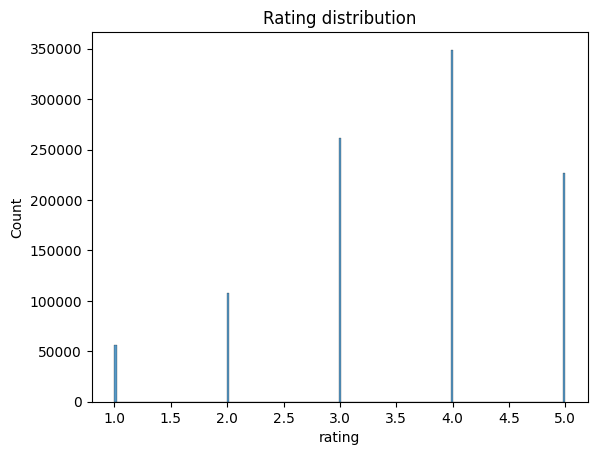

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

In [ ]:
mu = ratings_df['rating'].mean()

# 데이터셋 제작

In [ ]:
# def split_data(df, test_ratio = 0.1):
#     user_id_li = df['userId'].unique()
#     mask = []
#     for user_id in user_id_li:
#         _df = df[df['userId'] == user_id]
#         mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
#     neg_mask = [not x for x in mask]

#     train_data, test_data = df[mask], df[neg_mask]
#     return train_data, test_data

# train_df, val_df = split_data(df = ratings_df)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [ ]:
not_in_val_user_num = len(set(test_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(test_df['movieId'].unique().tolist()) - set(train_df['movieId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(test_df)}')

학습용 데이터에 없는 유저의 수 : 0
학습용 데이터에 없는 영화의 수 : 23
학습용 데이터의 수: 800167, 평가용 데이터의 수: 200042


In [ ]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['userId'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['movieId'].tolist()])
        self.rating = torch.tensor(self.df['rating'].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]
        rating = self.rating[idx]

        return user, item, rating

# 모델 정의

In [ ]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_user, num_factor)
        self.Q = nn.Embedding(num_item, num_factor)
        self.user_bias = nn.Embedding(num_user, 1)
        self.item_bias = nn.Embedding(num_item, 1)
        self.mu = mu

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)
        mu = self.mu

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu

        return output.view(-1)

# 학습 설정

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def rmse_loss(input, target):
    mse = criterion(input, target)
    rmse = torch.sqrt(mse)
    return rmse


def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device).float()

        optimizer.zero_grad()
        output = model(user, item)

        loss = rmse_loss(output, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device).float()

            output = model(user, item)

            loss = rmse_loss(output, rating)

            test_loss += loss.item()

            # 예측 레이블과 실제 레이블을 저장
            true_labels.extend(rating.tolist())
            predicted_labels.extend((output > 0).long().tolist())

    test_loss = test_loss / len(test_loader)

    # 정확성 지표 계산
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    return test_loss, precision, recall, f1

# 학습_original

In [ ]:
num_factor = 100
batch_size = 128
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.004

In [ ]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor, mu = mu).to(device)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = train_df, user_encoder = user_encoder, item_encoder = item_encoder)
test_dataset = CustomDataset(df = test_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [ ]:
best_metric = float('inf')
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

train_loss_list = []
test_loss_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_precision_list.append(test_precision)
    test_recall_list.append(test_recall)
    test_f1_list.append(test_f1)


    if test_loss < best_metric:
        best_metric = test_loss
        torch.save(model.state_dict(), model_dir + 'Matrix_Factorization.pt')
        counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
    else:
        counter += 1  # 최적 값이 아닌 경우 카운터 증가
        if counter >= patience:
            print("Early stopping triggered in : ", best_metric)
            break  # 얼리 스톱핑 조건 충족 시 학습 종료

[EPOCH: 1], Train Loss: 6.2847, Test Loss: 3.5041, Precision: 0.0467, Recall: 0.0467, F1-score: 0.0467


KeyboardInterrupt: ignored

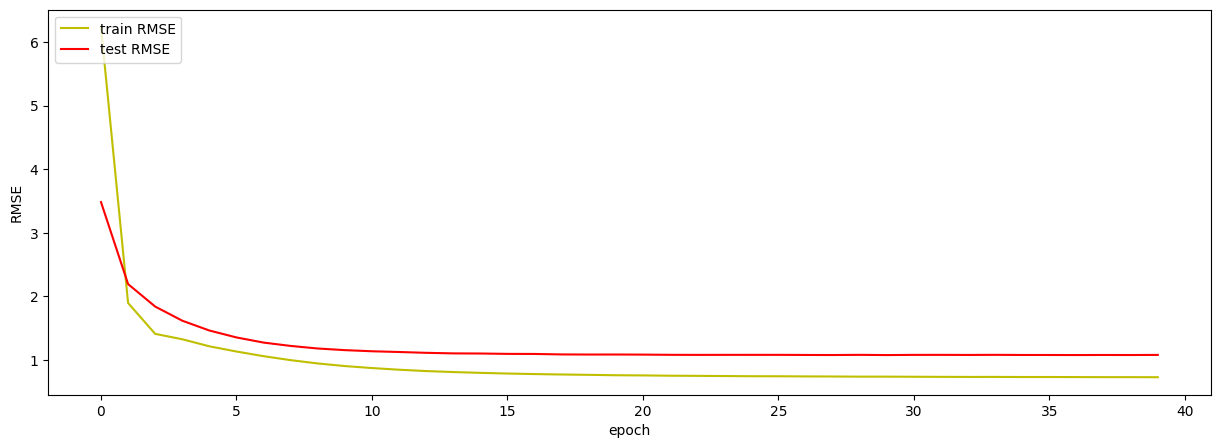

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(train_loss_list, 'y', label = 'train RMSE')
loss_ax.plot(test_loss_list, 'r', label = 'test RMSE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('RMSE')
loss_ax.legend(loc='upper left')

plt.show()

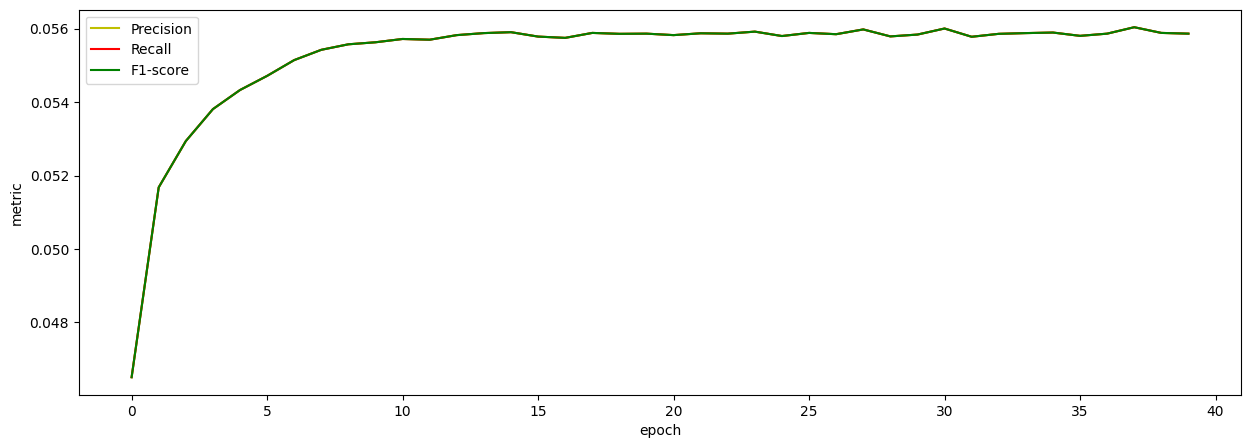

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(test_precision_list, 'y', label = 'Precision')
loss_ax.plot(test_recall_list, 'r', label = 'Recall')
loss_ax.plot(test_f1_list, 'g', label = 'F1-score')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('metric')
loss_ax.legend(loc='upper left')

plt.show()

본 학습에서 Embedding 한쪽을 고정시킨 후에 학습을 진행하면 ALS 방식이 된다. 그리고 데이터의 구조를 조금더 바꾸면 시간에 대한 역동성도 반영할 수 있고, 신뢰도를 추가하여 학습을 진행할 수도 있다.

In [ ]:
model.load_state_dict(torch.load(model_dir + 'Matrix_Factorization.pt'))

<All keys matched successfully>

# GAN

# 데이터 확인

In [4]:
ratings_df.drop('timestamp', axis=1, inplace=True)

In [5]:
ratings_df = ratings_df.rename(columns={'userId': 'UserID', 'movieId': 'MovieID', 'rating': 'Rating'})

In [6]:
path = '/content/gdrive/MyDrive/소융캡/dataset_1m/'
df_fake_GAN = pd.read_csv(path + 'df_fake_GAN.csv')
df_combined = pd.concat([ratings_df, df_fake_GAN], axis=0, ignore_index=True)

df_combined

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
2078899,14451,3950,2
2078900,10970,3951,1
2078901,11466,3951,1
2078902,11632,3951,1


In [7]:
num_user = df_combined['UserID'].nunique()
num_item = df_combined['MovieID'].nunique()

sparsity = 1 - len(df_combined) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 9918
전체 Item 수: 3725
행렬의 희소성: 0.9437


Text(0.5, 1.0, 'Rating distribution')

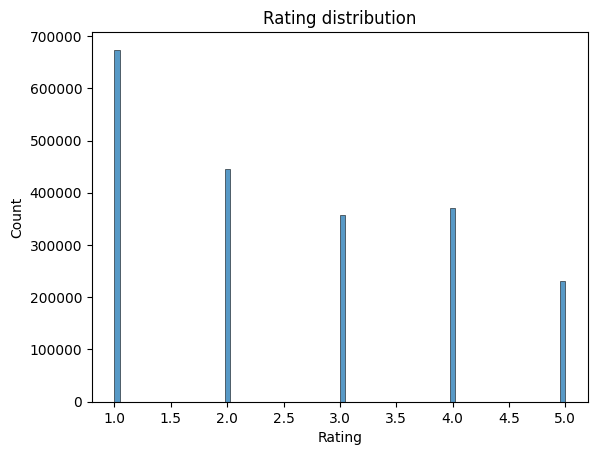

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_combined['Rating'])
plt.title('Rating distribution')

In [9]:
mu = df_combined['Rating'].mean()

# 데이터셋 제작

In [10]:
# def split_data(df, test_ratio = 0.1):
#     user_id_li = df['UserID'].unique()
#     mask = []
#     for user_id in user_id_li:
#         _df = df[df['UserID'] == user_id]
#         mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
#     neg_mask = [not x for x in mask]

#     train_data, test_data = df[mask], df[neg_mask]
#     return train_data, test_data

# train_df, val_df = split_data(df = df_combined)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_combined, test_size=0.2, random_state=42)


In [11]:
not_in_val_user_num = len(set(test_df['UserID'].unique().tolist()) - set(train_df['UserID'].unique().tolist()))
not_in_val_item_num = len(set(test_df['MovieID'].unique().tolist()) - set(train_df['MovieID'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(test_df)}')

학습용 데이터에 없는 유저의 수 : 30
학습용 데이터에 없는 영화의 수 : 23
학습용 데이터의 수: 1663123, 평가용 데이터의 수: 415781


In [12]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(df_combined['UserID'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(df_combined['MovieID'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['UserID'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['MovieID'].tolist()])
        self.rating = torch.tensor(self.df['Rating'].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]
        rating = self.rating[idx]

        return user, item, rating

# 모델 정의

In [14]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_user, num_factor)
        self.Q = nn.Embedding(num_item, num_factor)
        self.user_bias = nn.Embedding(num_user, 1)
        self.item_bias = nn.Embedding(num_item, 1)
        self.mu = mu

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)
        mu = self.mu

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu

        return output.view(-1)

# 학습 설정

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

def rmse_loss(input, target):
    mse = criterion(input, target)
    rmse = torch.sqrt(mse)
    return rmse


def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device).float()

        optimizer.zero_grad()
        output = model(user, item)

        loss = rmse_loss(output, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device).float()

            output = model(user, item)

            loss = rmse_loss(output, rating)

            test_loss += loss.item()

            # 예측 레이블과 실제 레이블을 저장
            true_labels.extend(rating.tolist())
            predicted_labels.extend((output > 0).long().tolist())

    test_loss = test_loss / len(test_loader)

    # 정확성 지표 계산
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    return test_loss, precision, recall, f1

# 학습_gan

In [16]:
num_factor = 100
batch_size = 128
epochs = 50 #30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.004 #0.005

In [17]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor, mu = mu).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = train_df, user_encoder = user_encoder, item_encoder = item_encoder)
test_dataset = CustomDataset(df = test_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [18]:
best_metric = float('inf')
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

train_loss_list_gan = []
test_loss_list_gan = []
test_precision_list_gan = []
test_recall_list_gan = []
test_f1_list_gan = []
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

    train_loss_list_gan.append(train_loss)
    test_loss_list_gan.append(test_loss)
    test_precision_list_gan.append(test_precision)
    test_recall_list_gan.append(test_recall)
    test_f1_list_gan.append(test_f1)


    if test_loss < best_metric:
        best_metric = test_loss
        torch.save(model.state_dict(), model_dir + 'M atrix_Factorization_gan.pt')
        counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
    else:
        counter += 1  # 최적 값이 아닌 경우 카운터 증가
        if counter >= patience:
            print("Early stopping triggered in :  ", best_metric)
            break  # 얼리 스톱핑 조건 충족 시 학습 종료

[EPOCH: 1], Train Loss: 4.4154, Test Loss: 1.8782, Precision: 0.2971, Recall: 0.2971, F1-score: 0.2971
[EPOCH: 2], Train Loss: 1.2406, Test Loss: 1.3320, Precision: 0.3133, Recall: 0.3133, F1-score: 0.3133
[EPOCH: 3], Train Loss: 1.1139, Test Loss: 1.0893, Precision: 0.3181, Recall: 0.3181, F1-score: 0.3181
[EPOCH: 4], Train Loss: 0.9601, Test Loss: 0.9755, Precision: 0.3202, Recall: 0.3202, F1-score: 0.3202
[EPOCH: 5], Train Loss: 0.8879, Test Loss: 0.9133, Precision: 0.3208, Recall: 0.3208, F1-score: 0.3208
[EPOCH: 6], Train Loss: 0.8285, Test Loss: 0.8812, Precision: 0.3212, Recall: 0.3212, F1-score: 0.3212
[EPOCH: 7], Train Loss: 0.7968, Test Loss: 0.8593, Precision: 0.3214, Recall: 0.3214, F1-score: 0.3214
[EPOCH: 8], Train Loss: 0.7729, Test Loss: 0.8492, Precision: 0.3214, Recall: 0.3214, F1-score: 0.3214
[EPOCH: 9], Train Loss: 0.7591, Test Loss: 0.8429, Precision: 0.3214, Recall: 0.3214, F1-score: 0.3214
[EPOCH: 10], Train Loss: 0.7481, Test Loss: 0.8366, Precision: 0.3216, Re

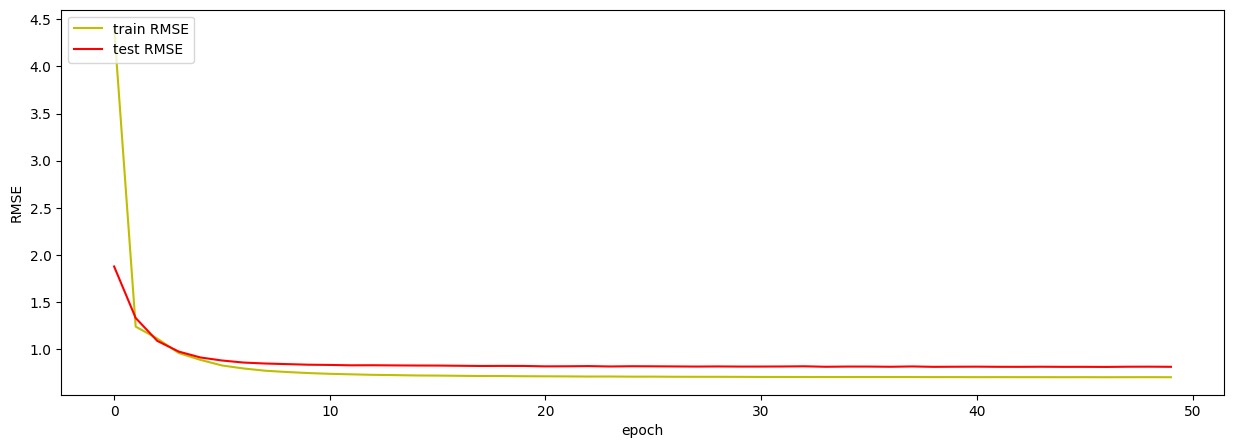

In [19]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(train_loss_list_gan, 'y', label = 'train RMSE')
loss_ax.plot(test_loss_list_gan, 'r', label = 'test RMSE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('RMSE')
loss_ax.legend(loc='upper left')

plt.show()

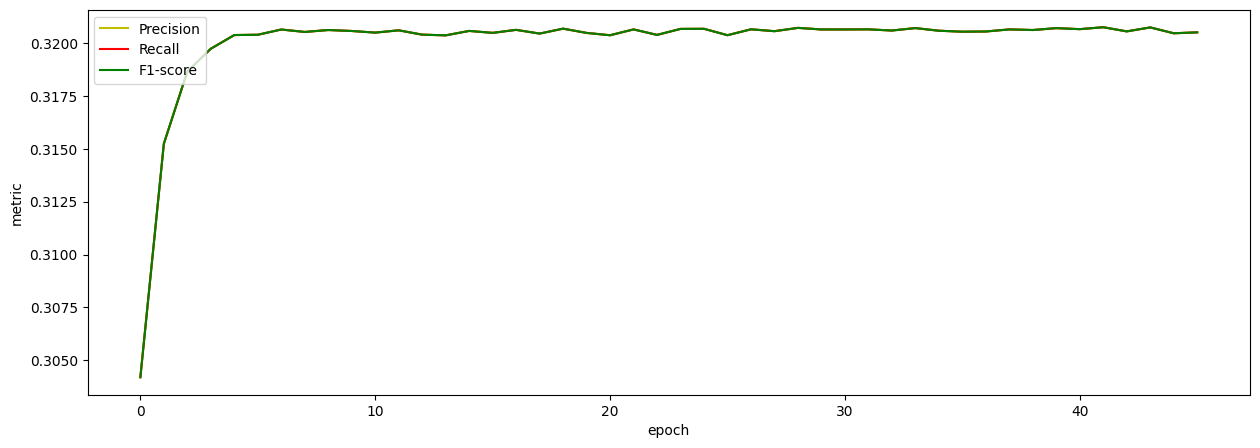

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(test_precision_list_gan, 'y', label = 'Precision')
loss_ax.plot(test_recall_list_gan, 'r', label = 'Recall')
loss_ax.plot(test_f1_list_gan, 'g', label = 'F1-score')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('metric')
loss_ax.legend(loc='upper left')

plt.show()

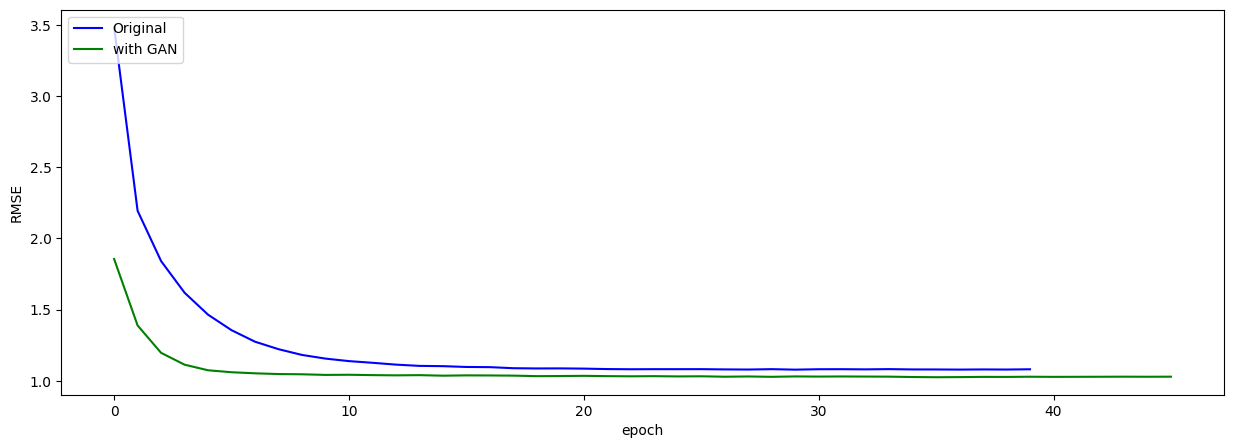

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(test_loss_list, 'b', label = 'Original')
loss_ax.plot(test_loss_list_gan, 'g', label = 'with GAN')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('RMSE')
loss_ax.legend(loc='upper left')

plt.show()

본 학습에서 Embedding 한쪽을 고정시킨 후에 학습을 진행하면 ALS 방식이 된다. 그리고 데이터의 구조를 조금더 바꾸면 시간에 대한 역동성도 반영할 수 있고, 신뢰도를 추가하여 학습을 진행할 수도 있다.

In [ ]:
model.load_state_dict(torch.load(model_dir + 'Matrix_Factorization_gan.pt'))

<All keys matched successfully>

# half만

In [ ]:
df_half = ratings_df.sample(n=500100)

In [ ]:
df_half

,userId,movieId,rating,timestamp
960578,5794,3421,5,958070355
385897,2257,3510,5,974590218
335314,1980,1254,5,1019107276
709948,4258,2301,4,968174198
81229,541,497,3,976125768
...,...,...,...,...
337921,1988,913,4,974703528
70104,474,2628,3,976239764
240603,1449,2003,2,974826009
108204,710,3524,4,978382159


In [ ]:
num_user = df_half['userId'].nunique()
num_item = df_half['movieId'].nunique()

sparsity = 1 - len(df_half) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 6040
전체 Item 수: 3619
행렬의 희소성: 0.9771


Text(0.5, 1.0, 'Rating distribution')

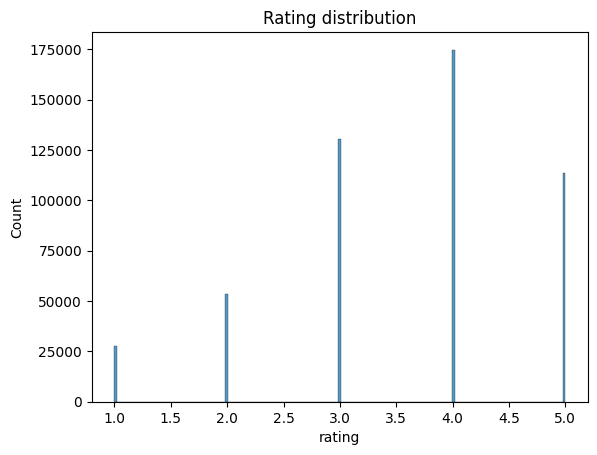

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_half['rating'])
plt.title('Rating distribution')

In [ ]:
mu = df_half['rating'].mean()

# 데이터셋 제작

In [ ]:
# def split_data(df, test_ratio = 0.1):
#     user_id_li = df['userId'].unique()
#     mask = []
#     for user_id in user_id_li:
#         _df = df[df['userId'] == user_id]
#         mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
#     neg_mask = [not x for x in mask]

#     train_data, test_data = df[mask], df[neg_mask]
#     return train_data, test_data

# train_df, val_df = split_data(df = ratings_df)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_half, test_size=0.2, random_state=42)

In [ ]:
not_in_val_user_num = len(set(test_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(test_df['movieId'].unique().tolist()) - set(train_df['movieId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(test_df)}')

학습용 데이터에 없는 유저의 수 : 0
학습용 데이터에 없는 영화의 수 : 36
학습용 데이터의 수: 400080, 평가용 데이터의 수: 100020


In [ ]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(df_half['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(df_half['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['userId'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['movieId'].tolist()])
        self.rating = torch.tensor(self.df['rating'].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]
        rating = self.rating[idx]

        return user, item, rating

# 모델 정의

In [ ]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_user, num_factor)
        self.Q = nn.Embedding(num_item, num_factor)
        self.user_bias = nn.Embedding(num_user, 1)
        self.item_bias = nn.Embedding(num_item, 1)
        self.mu = mu

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)
        mu = self.mu

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu

        return output.view(-1)

# 학습 설정

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def rmse_loss(input, target):
    mse = criterion(input, target)
    rmse = torch.sqrt(mse)
    return rmse


def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device).float()

        optimizer.zero_grad()
        output = model(user, item)

        loss = rmse_loss(output, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device).float()

            output = model(user, item)

            loss = rmse_loss(output, rating)

            test_loss += loss.item()

            # 예측 레이블과 실제 레이블을 저장
            true_labels.extend(rating.tolist())
            predicted_labels.extend((output > 0).long().tolist())

    test_loss = test_loss / len(test_loader)

    # 정확성 지표 계산
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    return test_loss, precision, recall, f1

In [ ]:
num_factor = 100
batch_size = 128
epochs = 50 #30
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.004 #0.005

In [ ]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor, mu = mu).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = train_df, user_encoder = user_encoder, item_encoder = item_encoder)
test_dataset = CustomDataset(df = test_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [ ]:
best_metric = float('inf')
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

train_loss_list_half = []
test_loss_list_half = []
test_precision_list_half = []
test_recall_list_half = []
test_f1_list_half = []
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

    train_loss_list_half.append(train_loss)
    test_loss_list_half.append(test_loss)
    test_precision_list_half.append(test_precision)
    test_recall_list_half.append(test_recall)
    test_f1_list_half.append(test_f1)


    if test_loss < best_metric:
        best_metric = test_loss
        torch.save(model.state_dict(), model_dir + 'M atrix_Factorization_gan.pt')
        counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
    else:
        counter += 1  # 최적 값이 아닌 경우 카운터 증가
        if counter >= patience:
            print("Early stopping triggered in :  ", best_metric)
            break  # 얼리 스톱핑 조건 충족 시 학습 종료

[EPOCH: 1], Train Loss: 7.9342, Test Loss: 5.9353, Precision: 0.0398, Recall: 0.0398, F1-score: 0.0398
[EPOCH: 2], Train Loss: 3.3515, Test Loss: 4.1059, Precision: 0.0436, Recall: 0.0436, F1-score: 0.0436
[EPOCH: 3], Train Loss: 1.8015, Test Loss: 3.3897, Precision: 0.0461, Recall: 0.0461, F1-score: 0.0461
[EPOCH: 4], Train Loss: 1.6536, Test Loss: 3.0237, Precision: 0.0473, Recall: 0.0473, F1-score: 0.0473
[EPOCH: 5], Train Loss: 1.5272, Test Loss: 2.7549, Precision: 0.0485, Recall: 0.0485, F1-score: 0.0485
[EPOCH: 6], Train Loss: 1.4320, Test Loss: 2.5524, Precision: 0.0493, Recall: 0.0493, F1-score: 0.0493
[EPOCH: 7], Train Loss: 1.3805, Test Loss: 2.3843, Precision: 0.0496, Recall: 0.0496, F1-score: 0.0496
[EPOCH: 8], Train Loss: 1.3215, Test Loss: 2.2341, Precision: 0.0501, Recall: 0.0501, F1-score: 0.0501
[EPOCH: 9], Train Loss: 1.2677, Test Loss: 2.0981, Precision: 0.0509, Recall: 0.0509, F1-score: 0.0509
[EPOCH: 10], Train Loss: 1.2175, Test Loss: 1.9885, Precision: 0.0510, Re

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(train_loss_list_half, 'y', label = 'train RMSE')
loss_ax.plot(test_loss_list_half, 'r', label = 'test RMSE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('RMSE')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(test_loss_list, 'b', label = 'Original')
loss_ax.plot(test_loss_list_half, 'g', label = 'half Original')
loss_ax.plot(test_loss_list_gan, 'g', label = 'with GAN')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('RMSE')
loss_ax.legend(loc='upper left')

plt.show()

# 코드 공부

## 데이터 불러오기

In [ ]:
ratings_df = pd.read_csv(data_dir + "ratings.dat", sep="::", engine="python",
                      names=["userId", "movieId", "rating", "timestamp"])
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [ ]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 6040
전체 Item 수: 3706
행렬의 희소성: 0.9553


Text(0.5, 1.0, 'Rating distribution')

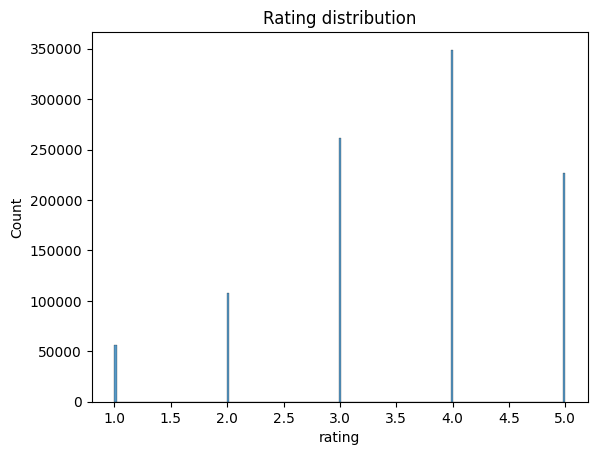

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

In [ ]:
mu = ratings_df['rating'].mean()

In [ ]:
mu

3.581564453029317

## 데이터셋 제작

In [ ]:
# def split_data(df, test_ratio = 0.1):
#     user_id_li = df['userId'].unique()
#     mask = []
#     for user_id in user_id_li:
#         _df = df[df['userId'] == user_id]
#         mask += [True if x == 1 else False for x in np.random.uniform(0, 1, (len(_df))) < 1 - test_ratio]
#     neg_mask = [not x for x in mask]

#     train_data, test_data = df[mask], df[neg_mask]
#     return train_data, test_data

# train_df, val_df = split_data(df = ratings_df)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [ ]:
not_in_val_user_num = len(set(test_df['userId'].unique().tolist()) - set(train_df['userId'].unique().tolist()))
not_in_val_item_num = len(set(test_df['movieId'].unique().tolist()) - set(train_df['movieId'].unique().tolist()))

print(f'학습용 데이터에 없는 유저의 수 : {not_in_val_user_num}')
print(f'학습용 데이터에 없는 영화의 수 : {not_in_val_item_num}')
print(f'학습용 데이터의 수: {len(train_df)}, 평가용 데이터의 수: {len(test_df)}')

학습용 데이터에 없는 유저의 수 : 0
학습용 데이터에 없는 영화의 수 : 23
학습용 데이터의 수: 800167, 평가용 데이터의 수: 200042


In [ ]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, user_encoder, item_encoder):
        self.df = df
        self.user_encoder, self.item_encoder, = user_encoder, item_encoder
        self.user = torch.tensor([self.user_encoder[i] for i in self.df['userId'].tolist()])
        self.item = torch.tensor([self.item_encoder[i] for i in self.df['movieId'].tolist()])
        self.rating = torch.tensor(self.df['rating'].tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user[idx]
        item = self.item[idx]
        rating = self.rating[idx]

        return user, item, rating

# 모델 정의

In [ ]:
from matplotlib import path
class MF(nn.Module):
    def __init__(self, num_user, num_item, num_factor, mu):
        super(MF, self).__init__()
        self.P = nn.Embedding(num_user, num_factor)
        self.Q = nn.Embedding(num_item, num_factor)
        self.user_bias = nn.Embedding(num_user, 1)
        self.item_bias = nn.Embedding(num_item, 1)
        self.mu = mu

    def forward(self, user, item):
        p_u = self.P(user)
        q_i = self.Q(item)
        b_u = self.user_bias(user)
        b_i = self.item_bias(item)
        mu = self.mu

        output = torch.sum((p_u * q_i), axis = 1) + torch.squeeze(b_u) + torch.squeeze(b_i) + mu

        return output.view(-1)

# 학습 설정

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def rmse_loss(input, target):
    mse = criterion(input, target)
    rmse = torch.sqrt(mse)
    return rmse


def train(model, train_loader):
    model.train()
    train_loss = 0

    for user, item, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device).float()

        optimizer.zero_grad()
        output = model(user, item)

        loss = rmse_loss(output, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    return train_loss


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device).float()

            output = model(user, item)

            loss = rmse_loss(output, rating)

            test_loss += loss.item()

            # 예측 레이블과 실제 레이블을 저장
            true_labels.extend(rating.tolist())
            predicted_labels.extend((output > 0).long().tolist())

    test_loss = test_loss / len(test_loader)

    # 정확성 지표 계산
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    return test_loss, precision, recall, f1

# 학습_original

In [ ]:
num_factor = 100
batch_size = 128
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr = 0.004

In [ ]:
model = MF(num_user = num_user, num_item = num_item, num_factor = num_factor, mu = mu).to(device)
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_dataset = CustomDataset(df = train_df, user_encoder = user_encoder, item_encoder = item_encoder)
test_dataset = CustomDataset(df = test_df, user_encoder = user_encoder, item_encoder = item_encoder)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [ ]:
best_metric = float('inf')
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

train_loss_list = []
test_loss_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

    print(f"[EPOCH: {epoch}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_precision_list.append(test_precision)
    test_recall_list.append(test_recall)
    test_f1_list.append(test_f1)


    if test_loss < best_metric:
        best_metric = test_loss
        torch.save(model.state_dict(), model_dir + 'Matrix_Factorization.pt')
        counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
    else:
        counter += 1  # 최적 값이 아닌 경우 카운터 증가
        if counter >= patience:
            print("Early stopping triggered in : ", best_metric)
            break  # 얼리 스톱핑 조건 충족 시 학습 종료

[EPOCH: 1], Train Loss: 6.2686, Test Loss: 3.4715, Precision: 0.0465, Recall: 0.0465, F1-score: 0.0465
[EPOCH: 2], Train Loss: 1.8985, Test Loss: 2.1804, Precision: 0.0517, Recall: 0.0517, F1-score: 0.0517
[EPOCH: 3], Train Loss: 1.4101, Test Loss: 1.8268, Precision: 0.0529, Recall: 0.0529, F1-score: 0.0529
[EPOCH: 4], Train Loss: 1.3283, Test Loss: 1.6063, Precision: 0.0538, Recall: 0.0538, F1-score: 0.0538
[EPOCH: 5], Train Loss: 1.2108, Test Loss: 1.4588, Precision: 0.0543, Recall: 0.0543, F1-score: 0.0543
[EPOCH: 6], Train Loss: 1.1347, Test Loss: 1.3490, Precision: 0.0546, Recall: 0.0546, F1-score: 0.0546
[EPOCH: 7], Train Loss: 1.0565, Test Loss: 1.2666, Precision: 0.0551, Recall: 0.0551, F1-score: 0.0551
[EPOCH: 8], Train Loss: 0.9961, Test Loss: 1.2147, Precision: 0.0552, Recall: 0.0552, F1-score: 0.0552
[EPOCH: 9], Train Loss: 0.9442, Test Loss: 1.1793, Precision: 0.0554, Recall: 0.0554, F1-score: 0.0554
[EPOCH: 10], Train Loss: 0.9056, Test Loss: 1.1541, Precision: 0.0556, Re